Example Notebook for using JNB Tools
====================================
Normally, for my lab notebook, this section would include my experimental details,
and a summary of the conclusions of this notebook. However, the data being used here
is not important, so I will just explain what is being done in each cell. Feel free to
copy this notebook as a template for new analyses.

Table of Contents:
1. Create a button to toggle on/off the raw code.
2. Import necessary modules for your analysis.
3. Set up plotting defaults.


Create a button to turn off/on the display of the raw code.
-----------------------------------------------------------
This button will work if viewing the raw notebook, or if exported to HTML, but not MD.
It is useful if you want to look back at your analysis, but are uninterested in seeing
the code. This is how I sometimes send research updates to Kevin.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


Importing modules.
------------------
I like to put this at the top of my notebook, all in one place, so that I can see my whole
python environment. The first line, `%matplotlib inline` ensures that plots are rendered
within the notebook. You can use `sys.path.append('path/to/module')` to add modules that are
not normally in your path.

In [2]:
# Set up Python environment

%matplotlib inline
import sys
sys.path.append('/nas/longleaf/home/psirving/JNBTools')
import plottingTools as pt
import numpy as np
import matplotlib.pyplot as plt
import shapemapperPlots as smp
import seaborn as sns
import pandas as pd

Setting up plotting defaults
----------------------------
This changes the defaults for pyplot and seaborn. Colors is just a colorscheme that I like.

In [3]:
# Set up plotting defaults

sns.set_style("ticks")
sns.set_context("talk")
colors = [
    '#a100ffff',  #Purple
    '#edc600ff',  #Yellow
    '#0092edff',  #Blue
    '#ff8300ff',  #Orange
    '#ff48e9ff',  #Pink
    '#3fd125ff'   #Green
         ]
sns.set_palette(colors)

Defining data path and reading in data
--------------------------------------
This is where I read in all of my data. For this example, I'm working directly
in the directory with my data files, but this may not be the case on longleaf.
The commented section below is how I usually point to my files on longleaf.

JNBTools works with pandas DataFrame objects, which are very easy to create from
most of our file formats. For reactivity profiles, I usually make a dictionary
where the key/value pairs are the sample name and DataFrame object for each profile.

For secondaryStructure.py, the object is built from file names, so no need to create
the data frame object first.

In [4]:
# Longleaf example:
# path = '/pine/scr/o/n/onyen/working-directory/'
# profile_suffix = '_rnasep_profile.txt'
# samples = ['Sample1, Sample2, Sample3, Sample4]

# profiles = {sample: pd.read_csv(path+'shapemapper_out/'+sample+profile_suffix, sep='\t') for sample in samples}
# histograms = {sample: pt.readHistograms(path+sample+'_shapemapper_log.txt') for sample in samples}

path = 'data/'
samples = ['example1', 'example2']
profile = {sample: pd.read_csv(path+sample+"_rnasep_profile.txt", sep='\t') for sample in samples}

# Only for example1
histograms = pt.readHistograms(path+"example_shapemapper_log.txt")

Quality Control: Mutations per molecule, read length distributions, and boxplots.
---------------------------------------------------------------------------------
I like to start with some quality control. Let's plot some summary metrics of our data.

I make these plots often, so at some point a class may be added to make these easier.

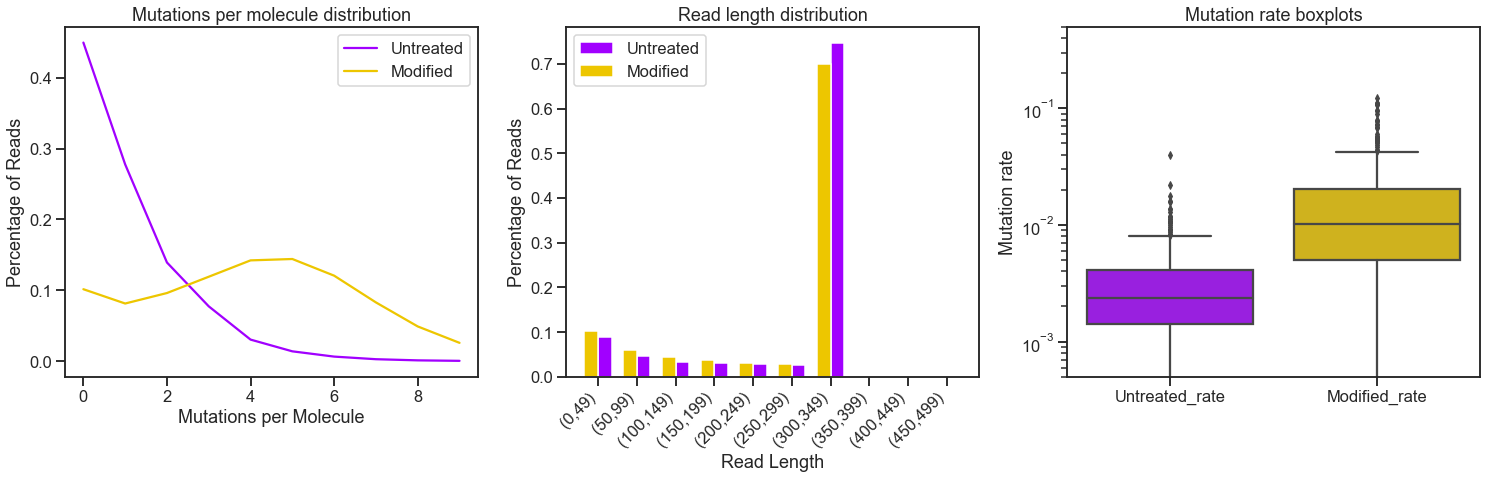

In [5]:
# Make Mutations per Molecule plots
fig, ax = plt.subplots(1,3, figsize=(21,7))

# plot 1: mutations per molecule
ax[0].plot(histograms['Mutation_count'][0:10], histograms['Untreated_mutations_per_molecule'][0:10], label="Untreated")
ax[0].plot(histograms['Mutation_count'][0:10], histograms['Modified_mutations_per_molecule'][0:10], label="Modified")
ax[0].legend()
ax[0].set(xlabel='Mutations per Molecule',
          ylabel='Percentage of Reads',
          title='Mutations per molecule distribution')

# plot 2: read length distribution
width=0.35
ax[1].bar(np.arange(10)+width/2, histograms["Untreated_read_length"][0:10], width, label="Untreated")
ax[1].bar(np.arange(10)-width/2, histograms["Modified_read_length"][0:10], width, label="Modified")
ax[1].legend()
ax[1].set(xticks=range(10),
          xlabel='Read Length',
          ylabel='Percentage of Reads',
          title='Read length distribution')
ax[1].set_xticklabels(histograms["Read_length"], rotation = 45, ha="right")

# plot 3: Mutation rate boxplots
ax[2] = sns.boxplot(data=profile['example1'][['Untreated_rate', 'Modified_rate']], orient='v')
ax[2].set(yscale='log',
          ylim=(0.0005, 0.5),
          ylabel='Mutation rate',
          title='Mutation rate boxplots')

plt.tight_layout();

Default ShapeMapper2 plots
--------------------------
These plots are the easiest, but also the least customizable. I basically just stole Steve's code.

Note: Error bars are there, but they are really small in this example.

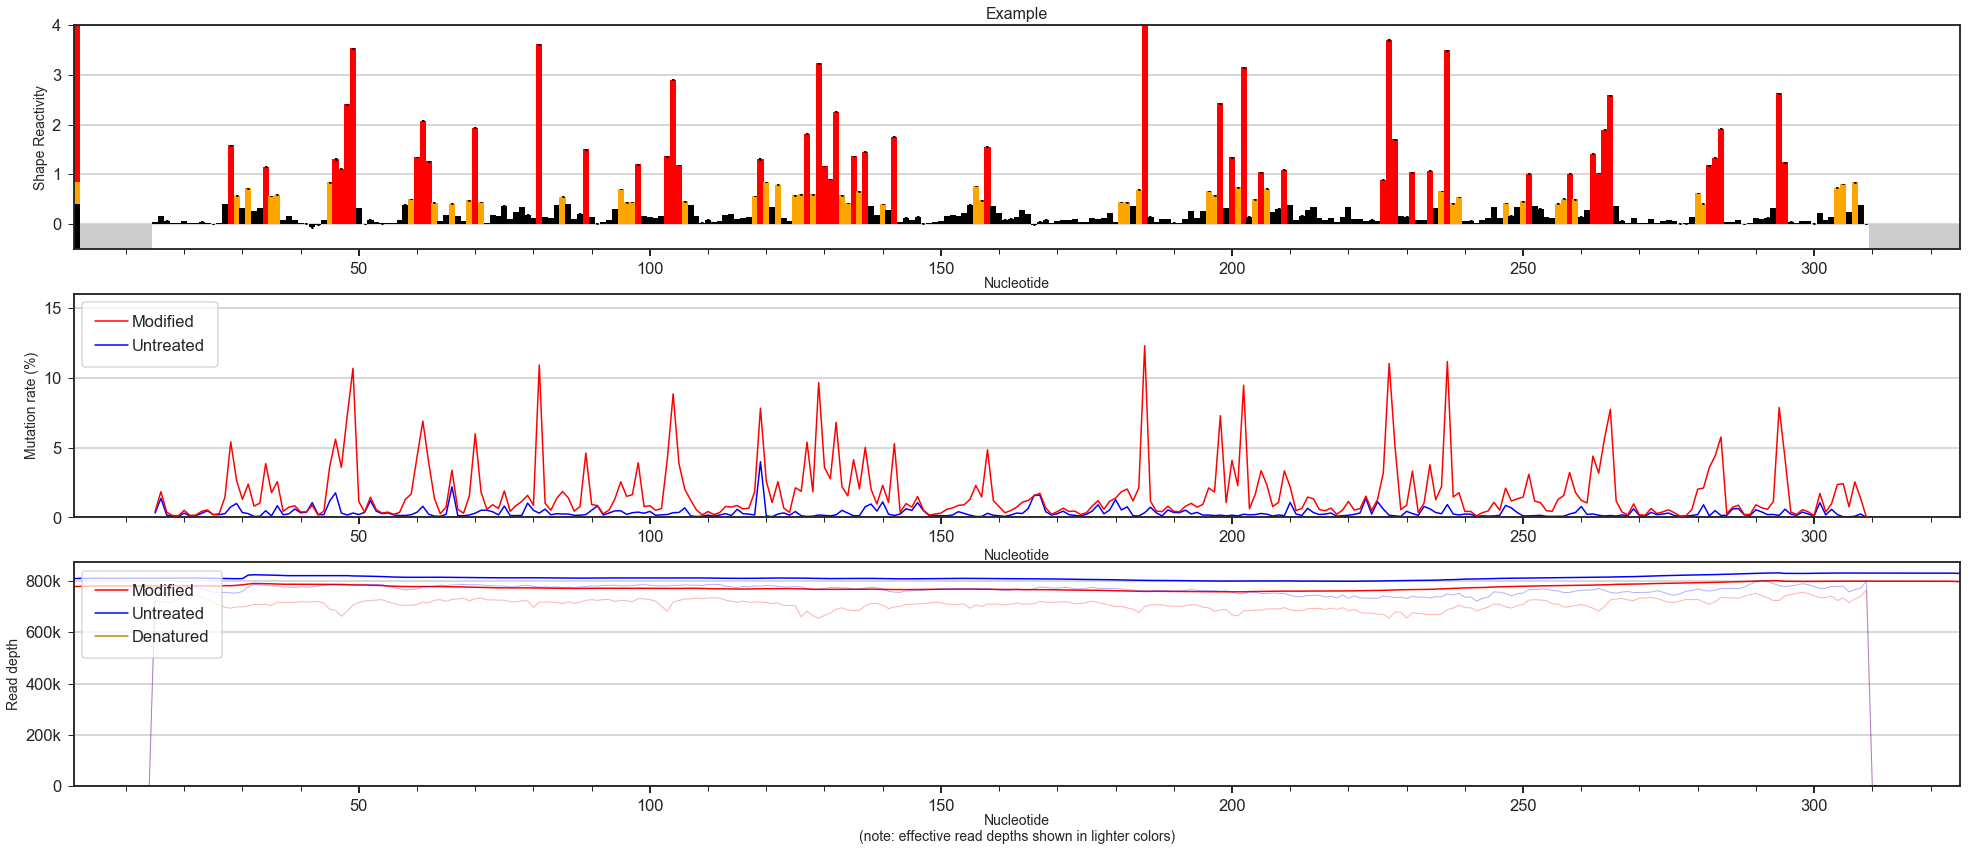

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(pt.getWidth(profile['example1']), 14))

smp.plotProfile(ax[0], profile['example1'], 'Example')
smp.plotMutationRates(ax[1], profile['example1'])
smp.plotDepth(ax[2], profile['example1'])

Skyline Plots
-------------
These types of plots make it easy to compare 2 or more reactivity profiles.

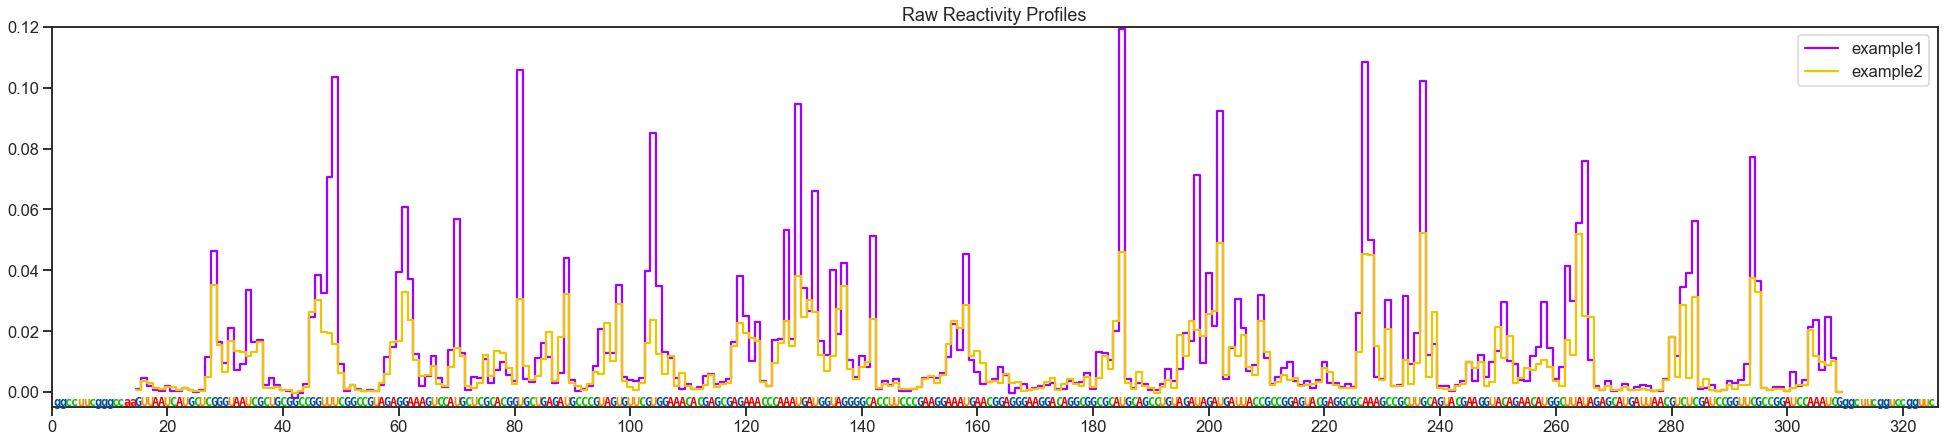

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(pt.getWidth(profile['example1']),7))

for sample in ['example1', 'example2']:
    pt.plotSkyline(ax, profile[sample], label=sample) # column defaults to 'Reactivity_profile'

ax.set(title='Raw Reactivity Profiles',
         xlim=[0,326],
         ylim=[-0.005, 0.12],
         xticks=range(0, 340, 20))
pt.addSeqBar(ax, profile['example1']) # ylim needs to be set before adding seq bar

ax.legend();

Regression Plots
----------------
Plots reactivity profile vs. reactivity profile and computes R^2 and slope.
If a ct file is provided, paired and unpaired nucleotides are colored seperately.

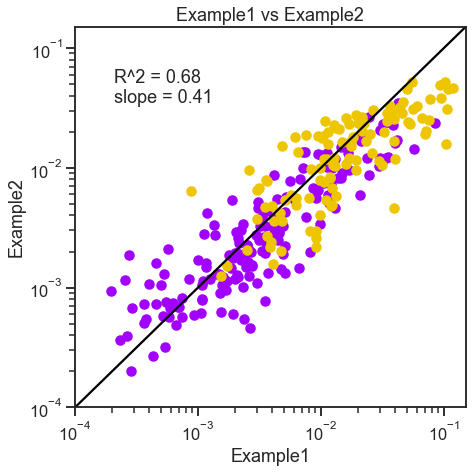

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))

pt.plotRegression(ax, profile['example1']['Reactivity_profile'], profile['example2']['Reactivity_profile'], ctfile=path+'RNaseP.ct')
ax.set(xscale='log',
       xlim=[0.0001,0.15],
       xlabel='Example1',
       yscale='log',
       ylim=[0.0001,0.15],
       ylabel='Example2',
       title='Example1 vs Example2');

Automatic plotting of ensemble reactivities as skyline plot
-----------------------------------------------------------

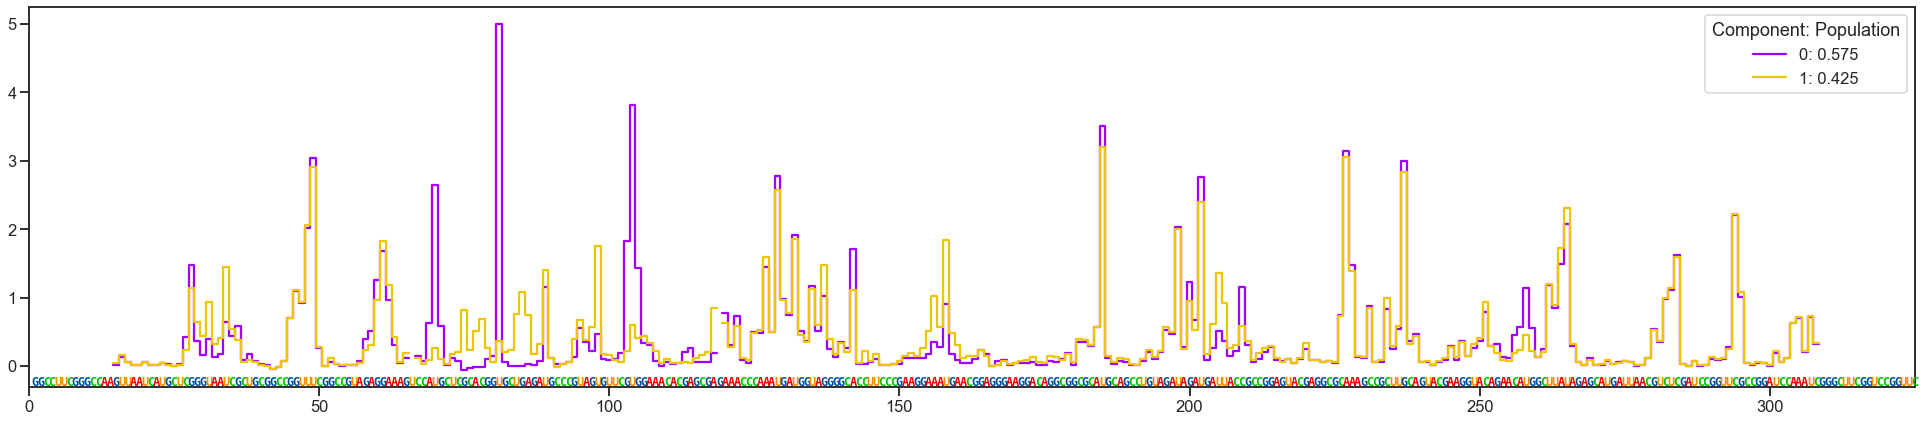

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(pt.getWidth(profile['example1']),7))

pt.plotBMprofiles(ax, path+"example_rnasep-reactivities.txt")